In [1]:
import string
import pandas as pd
import contractions
from tqdm import tqdm
import numpy as np
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
import torch
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder

/Users/julia.rozycka/Master/Multimodal Genre Classifier/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
df = pd.read_csv('data/fma_cut100_echonest_lyrics_fake_country.csv', header=[0, 1])

In [3]:
df.sample()

track    album                                                     \
  track_id comments         date_created        date_released engineer   
0     4688        0  2008-12-04 09:28:30  2004-09-25 00:00:00      NaN   

                                                                              \
  favorites    id                                        information listens   
0         1  1131  <p><a href="http://wfmu.org/playlists/shows/12...   11059   

                ...     track                                                  \
      producer  ... one_genre danceability    energy speechiness acousticness   
0  Mike Lupica  ...   Hip-Hop     0.493749  0.595018    0.063182     0.281542   

                                                             
  instrumentalness  liveness   valence   tempo track_folder  
0          0.93287  0.092266  0.519782  162.02            4  

[1 rows x 67 columns]

In [4]:
lyrics = ('track', 'lyrics')

In [5]:
def preprocess_for_nlp(data: pd.DataFrame) -> pd.DataFrame:
  punctuation_to_remove = string.punctuation.replace("'", "")
  data[lyrics] = data[lyrics].str.lower()
  data[lyrics] = data[lyrics].str.replace('chorus','')
  data[lyrics] = data[lyrics].str.replace('verse','')
  data[lyrics] = data[lyrics].str.replace(f"[{punctuation_to_remove}]", "", regex=True)
  data[lyrics] = data[lyrics].str.replace('2x','')
  data[lyrics] = data[lyrics].str.replace('x2','')
  data[lyrics] = data[lyrics].str.replace('3x','')
  data[lyrics] = data[lyrics].str.replace('x3','')
  data[lyrics] = data[lyrics].str.replace('4x','')
  data[lyrics] = data[lyrics].str.replace('x4','')
  data[lyrics] = data[lyrics].str.replace('5x','')
  data[lyrics] = data[lyrics].str.replace('x5','')
  data[lyrics] = data[lyrics].str.replace('6x','')
  data[lyrics] = data[lyrics].str.replace('x6','')
  data[lyrics] = data[lyrics].str.replace('7x','')
  data[lyrics] = data[lyrics].str.replace('x7','')
  data[lyrics] = data[lyrics].str.replace('8x','')
  data[lyrics] = data[lyrics].str.replace('x8','')
  data[lyrics] = data[lyrics].str.replace('9x','')
  data[lyrics] = data[lyrics].str.replace('x9','')
  data[lyrics] = data[lyrics].str.replace('\n', ' ')
  data[lyrics] = data[lyrics].str.replace(r'\s+', ' ', regex=True).str.strip()
  return data

In [6]:
df_pre = preprocess_for_nlp(data=df)

In [7]:
df_pre.sample()

track    album                                                     \
    track_id comments         date_created        date_released engineer   
110     4769        1  2008-12-23 11:40:05  2008-09-18 00:00:00      NaN   

                                                                        \
    favorites    id                                        information   
110         5  1670  <p> </p>\n<p> </p>\n<p>This set from <a href="...   

                      ...     track                                     \
    listens producer  ... one_genre danceability    energy speechiness   
110    7334      NaN  ...     Indie     0.268858  0.094615    0.030516   

                                                                           
    acousticness instrumentalness  liveness   valence  tempo track_folder  
110        0.963         0.010159  0.184471  0.110767  98.48            4  

[1 rows x 67 columns]

In [8]:
# Trzeba jeszcze usunac liczby o czym zapomnialam niestety
def remove_numbers(df: pd.DataFrame, column) -> pd.DataFrame:
    df[column] = df[column].str.replace(r'\d+', '', regex=True)
    #dodatkowo wyrzucamy apostrofy bo nam psują
    df[column] = df[column].str.replace("'","")
    return df

df_pre = remove_numbers(df_pre, lyrics)

In [9]:
df_pre.sample(5)

track    album                                            \
    track_id comments         date_created        date_released   
495    75034        0  2013-01-03 18:16:17  2012-11-15 00:00:00   
347    37730        0  2010-10-21 17:16:23  2010-10-21 00:00:00   
547    16242        0  2009-07-08 11:05:26  2005-03-01 00:00:00   
314    75388        0  2013-01-07 15:29:34  2010-01-28 00:00:00   
26     95911        0  2009-04-03 00:19:40                  NaN   

                                       \
            engineer favorites     id   
495  Justin Colletti         1  13220   
347      Dylan Going         1   7572   
547              NaN         0   3725   
314              NaN         1  13248   
26               NaN         2   2402   

                                                                               \
                                           information listens       producer   
495  <p>Put on your best shoes because California d...    2092  Julie Bennack   
347  <p><a href="http://threelobed.com/bardo/" titl...   15982            NaN   
547  <p>For several years I have been recording mus...     365            NaN   
314  <p>Aligned Archetype is Kellee Maize's Second ...   28556            NaN   
26   <p>If Alfred Nobel was famed for sticking vari...   23046            NaN   

     ...     track                                                  \
     ... one_genre danceability    energy speechiness acousticness   
495  ...       Pop     0.443953  0.801214    0.041004     0.020229   
347  ...      Rock     0.342897  0.475797    0.032990     0.505183   
547  ...   Country     0.237886  0.548873    0.028639     0.101142   
314  ...       Rap     0.490510  0.626205    0.249080     0.000601   
26   ...   Hip-Hop     0.541549  0.947793    0.474665     0.312942   

                                                                
    instrumentalness  liveness   valence    tempo track_folder  
495     3.004313e-01  0.362772  0.499818  120.962           75  
347     9.476406e-01  0.101868  0.292985   94.998           37  
547     1.993567e-01  0.289748  0.224092  140.494           16  
314     1.000000e-09  0.681413  0.458507  152.614           75  
26      2.006870e-05  0.598070  0.176768  156.133           95  

[5 rows x 67 columns]

In [10]:

def handle_contractions(df: pd.DataFrame) -> pd.DataFrame:
    tqdm.pandas(desc="Handling contractions")
    data = df.copy()
    data[lyrics] = data[lyrics].progress_apply(lambda x: contractions.fix(x))
    return data

df_without_contractions = handle_contractions(df_pre)

Handling contractions: 100%|██████████| 577/577 [00:00<00:00, 30014.68it/s]


In [36]:
df_without_contractions.sample(5)

track    album                                            \
    track_id comments         date_created        date_released   
539    12882        0  2009-05-14 07:10:28                  NaN   
364    66655        0  2012-06-19 12:13:52  2012-06-16 00:00:00   
399    14737        1  2009-06-09 10:08:57  2009-05-28 00:00:00   
411     3517        0  2008-12-04 09:26:38  2006-06-27 00:00:00   
295    23563        1  2010-01-13 12:39:20  2005-10-02 00:00:00   

                                                      \
                           engineer favorites     id   
539                             NaN         7   3077   
364  Jason Sigal w/ Justin Colletti         1  11962   
399                             NaN         2   3430   
411                     Gil Shuster         1    734   
295                             NaN         2   5152   

                                                                         ...  \
                                           information listens producer  ...   
539  <p>From Roger McGuinn's <a href="http://www.ib...  139700      NaN  ...   
364  <p>Vermont's King Tuff are led by Kyle Thomas,...    3102  Terre T  ...   
399  <p>Broadcast live from the <a href="http://www...  128132     WFMU  ...   
411  <p><span>London's masters of satirical, fallin...    5854      NaN  ...   
295  <p><strong>Tracky says about this release:</st...   12644      NaN  ...   

        track                                                  \
    one_genre danceability    energy speechiness acousticness   
539   Country     0.285837  0.225544    0.037179     0.994043   
364      Rock     0.172863  0.904603    0.061700     0.000008   
399      Rock     0.432605  0.547772    0.028539     0.237681   
411      Rock     0.700731  0.349948    0.044512     0.924427   
295       Rap     0.620717  0.416772    0.185103     0.738421   

                                                                
    instrumentalness  liveness   valence    tempo track_folder  
539         0.972870  0.114176  0.218131   81.286           12  
364         0.697396  0.404538  0.222476  115.109           66  
399         0.362177  0.506798  0.502842   91.133           14  
411         0.183471  0.115773  0.550739  110.581            3  
295         0.761077  0.122380  0.507701  170.436           23  

[5 rows x 67 columns]

In [37]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to lemmatize lyrics
def lemmatize_lyrics(lyrics):
    tokens = word_tokenize(lyrics)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Create sets
tqdm.pandas()
df['Lyrics_Lemmatized'] = df[lyrics].progress_apply(lemmatize_lyrics)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/julia.rozycka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 577/577 [00:00<00:00, 1586.09it/s]


In [38]:
df

track    album                                                     \
    track_id comments         date_created        date_released engineer   
0       4688        0  2008-12-04 09:28:30  2004-09-25 00:00:00      NaN   
1     124717       -1                  NaN                  NaN      NaN   
2      20473        0  2009-11-04 02:49:44                  NaN      NaN   
3      20472        0  2009-11-04 02:49:44                  NaN      NaN   
4      20471        0  2009-11-04 02:49:44                  NaN      NaN   
..       ...      ...                  ...                  ...      ...   
572    88864        2  2010-01-11 22:29:59                  NaN      NaN   
573    88867        2  2010-01-11 22:29:59                  NaN      NaN   
574    88868        2  2010-01-11 22:29:59                  NaN      NaN   
575    91934        0  2013-10-10 16:33:42  2013-09-28 00:00:00      NaN   
576    91935        0  2013-10-10 16:33:42  2013-09-28 00:00:00      NaN   

                                                                         \
    favorites     id                                        information   
0           1   1131  <p><a href="http://wfmu.org/playlists/shows/12...   
1          -1  18851                                                NaN   
2           0   4612  <p>ZONA MC, from Italy is the lone Artist to c...   
3           0   4612  <p>ZONA MC, from Italy is the lone Artist to c...   
4           0   4612  <p>ZONA MC, from Italy is the lone Artist to c...   
..        ...    ...                                                ...   
572        10   5114  <p><span style="color: #ffffff; font-family: '...   
573        10   5114  <p><span style="color: #ffffff; font-family: '...   
574        10   5114  <p><span style="color: #ffffff; font-family: '...   
575         0  15205  <div><span><span style="font-family: arial, he...   
576         0  15205  <div><span><span style="font-family: arial, he...   

                          ...        track                                     \
    listens     producer  ... danceability    energy speechiness acousticness   
0     11059  Mike Lupica  ...     0.493749  0.595018    0.063182     0.281542   
1        -1          NaN  ...     0.319768  0.854903    0.562493     0.434703   
2      2662          NaN  ...     0.415292  0.697336    0.433429     0.911632   
3      2662          NaN  ...     0.692302  0.770812    0.076767     0.552559   
4      2662          NaN  ...     0.523664  0.631565    0.427540     0.675857   
..      ...          ...  ...          ...       ...         ...          ...   
572   99511          NaN  ...     0.359909  0.434699    0.034597     0.418089   
573   99511          NaN  ...     0.599729  0.628798    0.044218     0.025069   
574   99511          NaN  ...     0.506025  0.490676    0.026642     0.019521   
575    4828          NaN  ...     0.490598  0.407893    0.025093     0.721706   
576    4828          NaN  ...     0.663895  0.362650    0.026750     0.841821   

                                                                \
    instrumentalness  liveness   valence    tempo track_folder   
0       9.328697e-01  0.092266  0.519782  162.020            4   
1       5.000000e-10  0.395102  0.723825   86.272          124   
2       1.760380e-02  0.099029  0.764465  169.933           20   
3       7.340639e-01  0.110137  0.429266   91.759           20   
4       7.068696e-03  0.111112  0.148784   87.667           20   
..               ...       ...       ...      ...          ...   
572     7.601249e-01  0.201513  0.154723  169.333           88   
573     3.190354e-02  0.113036  0.410850  139.989           88   
574     2.457100e-06  0.097218  0.276292  107.049           88   
575     1.701373e-02  0.111040  0.174899  101.202           91   
576     1.511013e-02  0.237332  0.379564   97.634           91   

                                     Lyrics_Lemmatized  
                                                        
0    written wo

In [39]:
# Check when track language code is different than 'en' or NaN
df['track', 'language_code'].value_counts()

(track, language_code)
en    215
it      8
es      1
Name: count, dtype: int64

In [40]:
# Filter out non-English lyrics -> delete row when it or es
df = df[df['track', 'language_code'].isin(['en', np.nan])]

In [41]:
df.count()

track              track_id         568
album              comments         568
                   date_created     561
                   date_released    437
                   engineer         185
                                   ... 
track              liveness         568
                   valence          568
                   tempo            568
                   track_folder     568
Lyrics_Lemmatized                   568
Length: 68, dtype: int64

In [42]:
df['Lyrics_Lemmatized'].sample(5)

269    this crowd a fleshy lake the throng a smallish...
317    the bloom of youth shone from her lovely face ...
278    one two three and to the fo snoop doggy dogg a...
386    hold out your hand let me see the truth give m...
468    i ve never felt love like this before i never ...
Name: Lyrics_Lemmatized, dtype: object

In [46]:
# Load model
device = 'mps'

# Initialize tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")
model = RobertaForSequenceClassification.from_pretrained(
    "distilroberta-base",
    num_labels=8,
    problem_type="multi_label_classification"
).to(device)

model.load_state_dict(torch.load("models/lyrics_genre_model_alphabetically.pt", map_location=device, weights_only=True))
model.to(device)
model.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [49]:
df

track    album                                                     \
    track_id comments         date_created        date_released engineer   
0       4688        0  2008-12-04 09:28:30  2004-09-25 00:00:00      NaN   
1     124717       -1                  NaN                  NaN      NaN   
9      26034        0  2010-02-22 11:37:22                  NaN      NaN   
11     13767        0  2009-05-26 12:11:30  2005-01-01 00:00:00      NaN   
12     11298        2  2009-04-22 11:20:27  2004-11-12 00:00:00      NaN   
..       ...      ...                  ...                  ...      ...   
572    88864        2  2010-01-11 22:29:59                  NaN      NaN   
573    88867        2  2010-01-11 22:29:59                  NaN      NaN   
574    88868        2  2010-01-11 22:29:59                  NaN      NaN   
575    91934        0  2013-10-10 16:33:42  2013-09-28 00:00:00      NaN   
576    91935        0  2013-10-10 16:33:42  2013-09-28 00:00:00      NaN   

                                                                         \
    favorites     id                                        information   
0           1   1131  <p><a href="http://wfmu.org/playlists/shows/12...   
1          -1  18851                                                NaN   
9           0   5637  <p>Only a taste of their unique sound, the <em...   
11          0   3234  <p>\n01. Majik's Theme 2005<br />\n02. Skinny ...   
12         24   2769  <div class="pgToolsSub"><strong>This CD was di...   
..        ...    ...                                                ...   
572        10   5114  <p><span style="color: #ffffff; font-family: '...   
573        10   5114  <p><span style="color: #ffffff; font-family: '...   
574        10   5114  <p><span style="color: #ffffff; font-family: '...   
575         0  15205  <div><span><span style="font-family: arial, he...   
576         0  15205  <div><span><span style="font-family: arial, he...   

                          ...        track                                     \
    listens     producer  ... danceability    energy speechiness acousticness   
0     11059  Mike Lupica  ...     0.493749  0.595018    0.063182     0.281542   
1        -1          NaN  ...     0.319768  0.854903    0.562493     0.434703   
9      4635          NaN  ...     0.717148  0.362344    0.497148     0.092770   
11     5664          NaN  ...     0.471251  0.444563    0.403452     0.263813   
12   123950          NaN  ...     0.869960  0.777364    0.175956     0.689857   
..      ...          ...  ...          ...       ...         ...          ...   
572   99511          NaN  ...     0.359909  0.434699    0.034597     0.418089   
573   99511          NaN  ...     0.599729  0.628798    0.044218     0.025069   
574   99511          NaN  ...     0.506025  0.490676    0.026642     0.019521   
575    4828          NaN  ...     0.490598  0.407893    0.025093     0.721706   
576    4828          NaN  ...     0.663895  0.362650    0.026750     0.841821   

                                                                \
    instrumentalness  liveness   valence    tempo track_folder   
0       9.328697e-01  0.092266  0.519782  162.020            4   
1       5.000000e-10  0.395102  0.723825   86.272          124   
9       8.368900e-06  0.235586  0.607779   58.174           26   
11      1.810000e-06  0.251294  0.622810   94.737           13   
12      4.101931e-01  0.084764  0.858421  112.990           11   
..               ...       ...       ...      ...          ...   
572     7.601249e-01  0.201513  0.154723  169.333           88   
573     3.190354e-02  0.113036  0.410850  139.989           88   
574     2.457100e-06  0.097218  0.276292  107.049           88   
575     1.701373e-02  0.111040  0.174899  101.202           91   
576     1.511013e-02  0.237332  0.379564   97.634           91   

                                     Lyrics_Lemmatized  
                                                        
0    written wo

In [51]:
# Load dataset
# Prepare labels
y = df[('track','one_genre')]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = np.eye(len(label_encoder.classes_))[y]  # One-hot encode genres
print(label_encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))
X = df['Lyrics_Lemmatized']


# Check the shape of the splits
print(f'Data set: {X.shape[0]} samples')

['Country' 'Hip-Hop' 'Indie' 'Jazz' 'Metal' 'Pop' 'Rap' 'Rock']
Data set: 568 samples


In [52]:
class LyricsGenreDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.tolist()
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": label,
        }

In [53]:
# Create datasets and dataloaders
batch_size = 24

dataset = LyricsGenreDataset(X, y, tokenizer)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Define loss and optimizer
#optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
#loss_fn = torch.nn.BCEWithLogitsLoss()

In [54]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model_single_genre(model, test_loader, device):
    model.eval()
    test_preds, test_labels, test_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # Get probabilities
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            test_probs.extend(probs)

            test_preds.extend(np.argmax(probs, axis=1))
            test_labels.extend(np.argmax(labels.cpu().numpy(), axis=1))

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average="macro")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test F1 Score: {test_f1}")

    return test_labels, test_preds, test_probs

# Run evaluation and get predictions and labels
test_labels, test_preds, test_probs = evaluate_model_single_genre(model, data_loader, device)

Test Accuracy: 0.41901408450704225
Test F1 Score: 0.34765093382331547


In [55]:
from sklearn.metrics import classification_report

def classification_report_single_genre(test_preds, test_labels):
    print(classification_report(test_labels, test_preds, target_names=list(label_encoder.classes_)))

# Use this function as needed to print the classification report
classification_report_single_genre(test_preds, test_labels)

              precision    recall  f1-score   support

     Country       0.40      0.07      0.11        60
     Hip-Hop       0.33      0.17      0.23        35
       Indie       0.29      0.78      0.43        95
        Jazz       0.67      0.95      0.78        82
       Metal       0.37      0.86      0.52        51
         Pop       0.22      0.02      0.04        99
         Rap       0.70      0.65      0.67        46
        Rock       0.00      0.00      0.00       100

    accuracy                           0.42       568
   macro avg       0.37      0.44      0.35       568
weighted avg       0.34      0.42      0.32       568



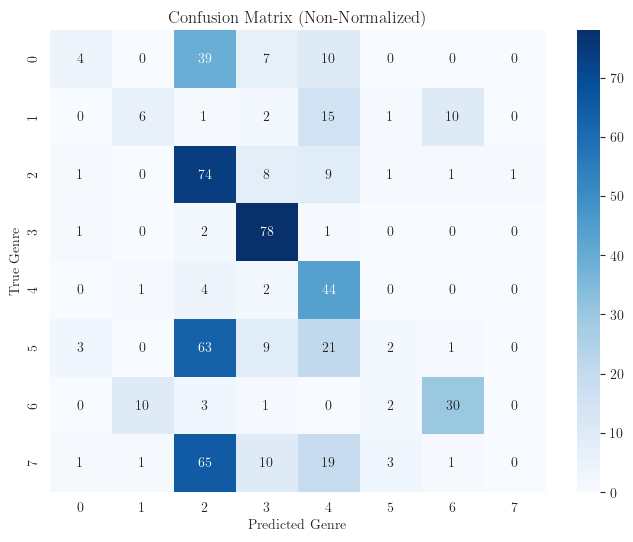

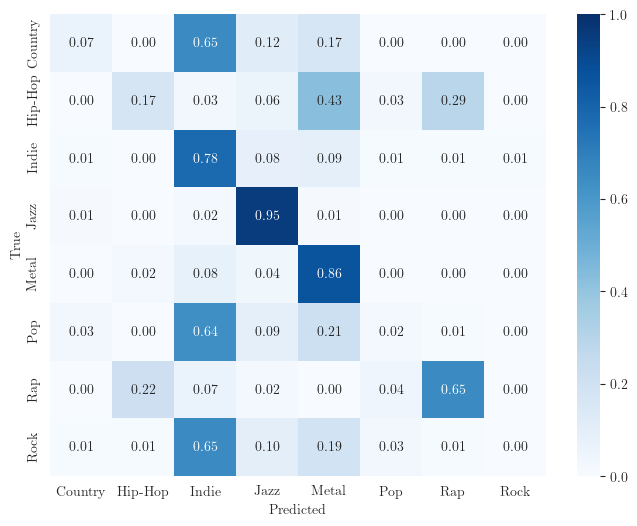

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def plot_single_confusion_matrix(test_labels, test_preds, label_names):
    cm = confusion_matrix(test_labels, test_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Use latex
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot Non-Normalized
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (Non-Normalized)")
    plt.ylabel("True Genre")
    plt.xlabel("Predicted Genre")
    plt.show()

    # Plot Normalized
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_names, yticklabels=label_names, vmax=1.0)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    # Save as png
    plt.savefig("confusion_matrix_normalized.png", dpi=300)
    plt.show()

# Plot single confusion matrix
plot_single_confusion_matrix(test_labels, test_preds, list(label_encoder.classes_))




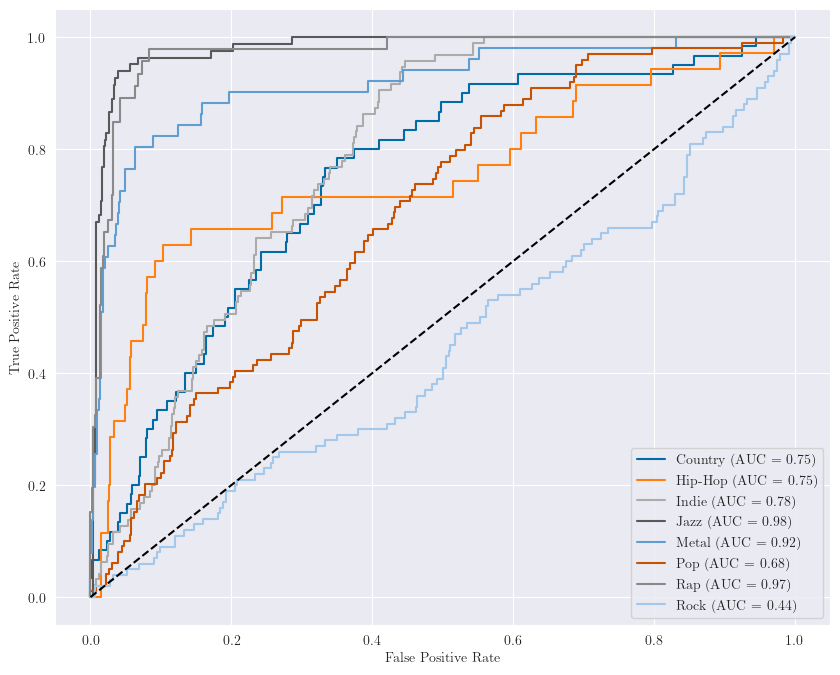

In [70]:
# Print auc-roc curve for each class on one plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Run evaluation and get predictions, labels, and probabilities

# Get the true positive rate and false positive rate
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):  # Assuming 8 classes
    fpr[i], tpr[i], _ = roc_curve((np.array(test_labels) == i).astype(int), np.array(test_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")  # Use label_encoder.classes_ for genre names
plt.plot([0, 1], [0, 1], "k--")
# Set style
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.style.context('tableau-colorblind10')

plt.legend(loc="lower right")  # Adjust legend location if needed
plt.style.use('fast')
plt.style.context('fast')
plt.savefig("auc_roc_roberta.png", dpi=300)

plt.show()



